In [16]:
''' Comand Prompt'''

import __init__
import gp_class
import gp_functions
import mpc_class
import optimize

import pandas as pd
import numpy as np
import casadi as ca
import scipy.linalg
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle

from mpc_class import MPC
from gp_class import GP

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Set

In [17]:
# Data Set

df = pd.read_csv('data_measured_random_data.csv')

In [18]:
def _get_x(df):
    X1 = df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6']].shift(1)
    X2 = df[['Load1', 'Load2', 'Load3', 'Gen2', 'Wind1', 'Wind2', 'Solar1', 'Solar2']]
    X = pd.merge(X1, X2, left_index=True, right_index=True)
    return X.iloc[1:].iloc[:-1]


def _get_y(df):
    y = df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6']]
    return y.iloc[1:].iloc[:-1]


X = _get_x(df)
Y = _get_y(df)

In [19]:
# Input Set
X.head()

,I1,I2,I3,I4,I5,I6,Load1,Load2,Load3,Gen2,Wind1,Wind2,Solar1,Solar2
1,4.826812,1.559757,1.491426,0.555835,4.670855,3.726221,80.066312,70.151738,37.260175,-195.780411,58.887284,38.719489,23.396309,34.837300
2,4.972427,1.186117,1.691754,0.256052,5.025643,3.882505,76.927805,67.401871,35.799619,-148.049877,34.425818,46.702309,18.864183,0.061175
3,4.702279,1.561927,1.504734,0.733486,4.954366,3.626683,75.076195,65.779545,34.937942,-172.783924,49.174016,31.112210,1.884806,38.319755
4,4.610159,1.027667,1.452916,0.586922,4.700351,3.711500,72.259865,63.311960,33.627316,-187.342371,50.603953,31.689670,20.829394,27.621705
5,4.879579,1.288133,1.746052,0.323943,4.930327,3.899324,67.067030,58.762151,31.210745,-210.918009,54.917138,36.965332,16.784155,35.702910


In [20]:
# Output Set
Y.head()

,I1,I2,I3,I4,I5,I6
1,4.972427,1.186117,1.691754,0.256052,5.025643,3.882505
2,4.702279,1.561927,1.504734,0.733486,4.954366,3.626683
3,4.610159,1.027667,1.452916,0.586922,4.700351,3.711500
4,4.879579,1.288133,1.746052,0.323943,4.930327,3.899324
5,4.907117,1.025208,1.852065,0.519815,5.137177,3.963880


In [15]:
Nx = Y.shape[1]
Nu = 4
Nd = 4

n_train = 200
n_test = n_train + 100

X_train = X.iloc[:n_train] #168 
Y_train = Y.iloc[:n_train]
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()


X_test = X.iloc[n_train:n_test]
Y_test = Y.iloc[n_train:n_test]

X_d = X.iloc[n_train:n_test, Nx+Nu:Nx+Nu+Nd]

X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
X_d = X_d.to_numpy()

x0 = Y_train[-1]
u0 = X_train[-1, Nx:Nx+Nu]

# 1. TA

# GP

In [16]:
""" Time Sampling """
dt = 1


""" Options for hyper-parameter optimization """
solver_opts = {}
#solver_opts['ipopt.linear_solver'] = 'ma27' # Faster plugin solver than default
solver_opts['expand']= False                # Choise between SX or MX graph


print('*****************')
print('GP')
print('*****************')
gp = GP(X_train, Y_train, dt, mean_func='zero', optimizer_opts=solver_opts, gp_method='TA', 
        normalize=True, multistart=1)


print('*****************')
print('Hyper_parameters')
print('*****************')
gp.print_hyper_parameters()


print('*****************')
print('Validation')
print('*****************')
MSE, SMSE, MNLP = gp.validate(X_test, Y_test)
print('MSE:', MSE)
print('SMSE:', SMSE)
print('MNLP:', MNLP)

size = gp.get_size()
print('size:',size)

*****************
GP
*****************

________________________________________
# Optimizing hyperparameters (N=200)
----------------------------------------


C:\Users\MILE\Desktop\MPCGP Los.Alam - finished project\MPC_GP\optimize.py:467: OptimizeWarning: Unknown solver options: expand
  method='SLSQP', options=options, bounds=bounds, tol=1e-12)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1059.4526252249625
            Iterations: 69
            Function evaluations: 1742
            Gradient evaluations: 65
* State 0:  19.770722 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -555.4231777553157
            Iterations: 72
            Function evaluations: 1829
            Gradient evaluations: 71
* State 1:  20.641227 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -253.10893579094096
            Iterations: 289
            Function evaluations: 5378
            Gradient evaluations: 289
* State 2:  60.974221 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -305.53059145254736
            Iterations: 793
            Function evaluations: 14877
            Gradient evaluations: 793
* State 3:  171.978905 s
Optimization terminated successfully.    (E

# MPC

In [17]:
""" Limits in the MPC problem """
#ulb = [0.,    0.,  0.,   -150.]
#uub = [133., 116., 62.,   50.]
#xlb = [4,   0.5,   0.05,   0.1,     3.2]
#xub = [5.2,    2,     2,     1.7,     5.2]


ulb = [df['Load1'].min(), df['Load2'].min(), df['Load3'].min(), df['Gen2'].min()]
uub = [df['Load1'].max(), df['Load2'].max(), df['Load3'].max(), df['Gen2'].max()]
#xlb = [df['I1'].min(), df['I2'].min(), df['I3'].min(), df['I4'].min(), df['I5'].min(), df['I6'].min(), df['V4'].min()]
#xub = [df['I1'].max(), df['I2'].max(), df['I3'].max(), df['I4'].max(), df['I5'].max(), df['I6'].max(), df['V4'].max()]

xlb = [df['I1'].min()-1, df['I2'].min()-1, df['I3'].min()-1, df['I4'].min()-1, df['I5'].min()-1, df['I6'].min()-1]
xub = [df['I1'].max()+1, df['I2'].max()+1, df['I3'].max()+1, df['I4'].max()+1, df['I5'].max()+1, df['I6'].max()+1]



""" Initial state, input and set point  """
#x_sp = np.array([4.5, 1.2, 1, 1.2, 4.2])

x_sp = np.array([df['I1'].mean(), df['I2'].mean(), df['I3'].mean(), df['I4'].mean(), df['I5'].mean(), df['I6'].mean()])
x0 = x0
u0 = u0


""" Penalty matrices """
#Q = np.diag([10, 10])  
#R = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
#S = np.diag([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

""" Options to pass to the MPC solver """
solver_opts = {
            #'ipopt.linear_solver' : 'ma27',    # Plugin solver from HSL
            'ipopt.max_cpu_time' : 300,
            'expand' : True,
            'ipopt.expect_infeasible_problem' : 'yes'
}




""" Build MPC solver """
mpc = MPC(horizon=5*dt, Xd=X_d, gp=gp,
           gp_method='TA',
           ulb=ulb, uub=uub, xlb=xlb, xub=xub, Q=None, R=None, S=None,
           terminal_constraint=None, costFunc='quad', feedback=False,
           solver_opts=solver_opts, discrete_method='gp'
           )


________________________________________
# Time to build mpc solver: 212.431679 sec
# Number of variables: 236
# Number of equality constraints: 162
# Number of inequality constraints: 100
----------------------------------------



Solving MPC with 5 step horizon
* t=0.000000: Restoration_Failed - 3.789840 sec
* t=1.000000: Restoration_Failed - 1.965880 sec
* t=2.000000: Solve_Succeeded - 15.796989 sec
* t=3.000000: Solve_Succeeded - 12.626797 sec
* t=4.000000: Solve_Succeeded - 2.183754 sec
* t=5.000000: Solve_Succeeded - 1.757999 sec
* t=6.000000: Solve_Succeeded - 6.107516 sec
* t=7.000000: Solve_Succeeded - 6.989013 sec
* t=8.000000: Solve_Succeeded - 15.826972 sec
* t=9.000000: Solve_Succeeded - 3.204173 sec
* t=10.000000: Solve_Succeeded - 17.123231 sec
* t=11.000000: Solve_Succeeded - 2.182754 sec
* t=12.000000: Solve_Succeeded - 9.118798 sec
* t=13.000000: Solve_Succeeded - 8.693039 sec
* t=14.000000: Solve_Succeeded - 9.197753 sec
* t=15.000000: Solve_Succeeded - 1.695034 sec
* t=16.000000: Solve_Succeeded - 12.813691 sec
* t=17.000000: Solve_Succeeded - 2.287693 sec
* t=18.000000: Solve_Succeeded - 9.374653 sec
* t=19.000000: Solve_Succeeded - 6.929049 sec


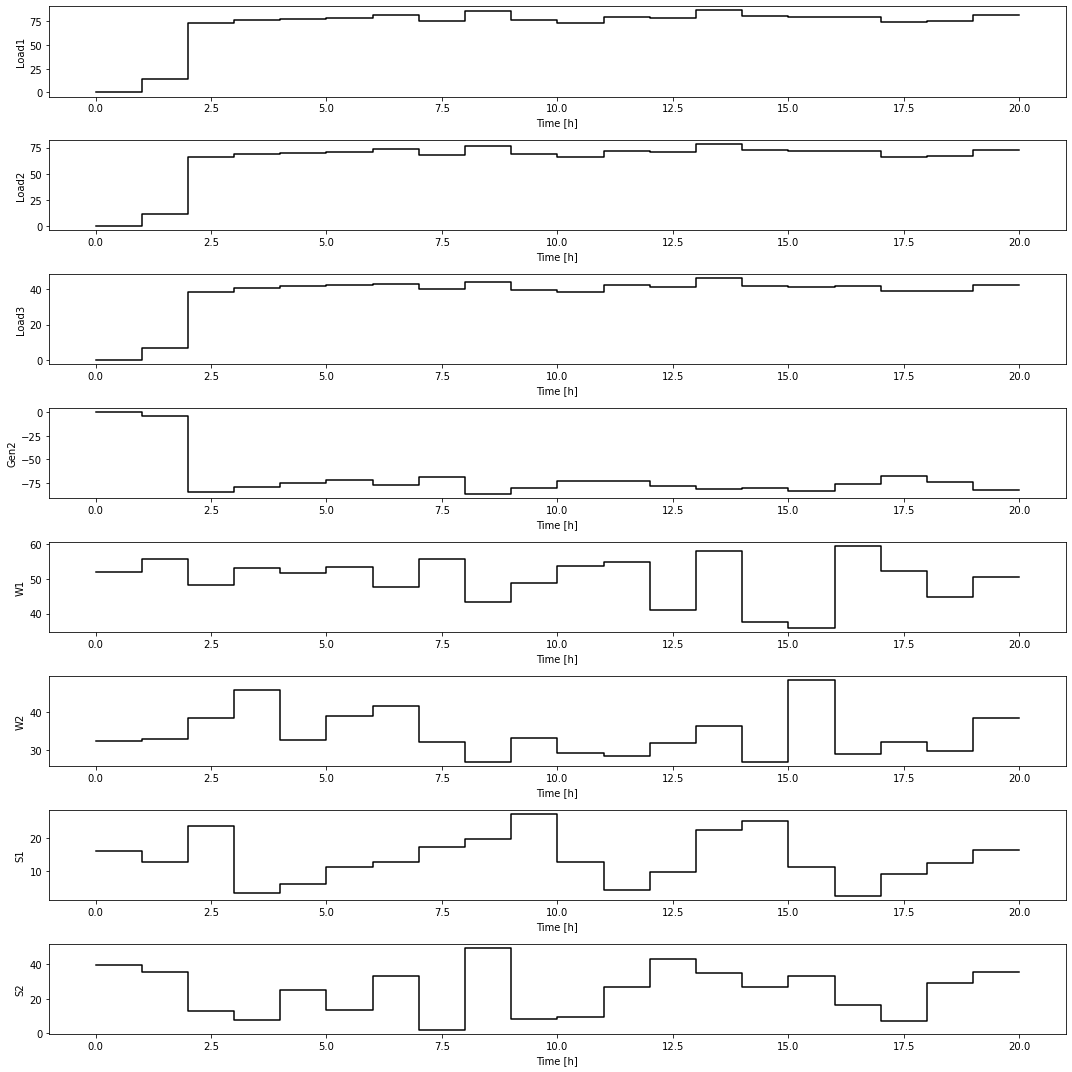

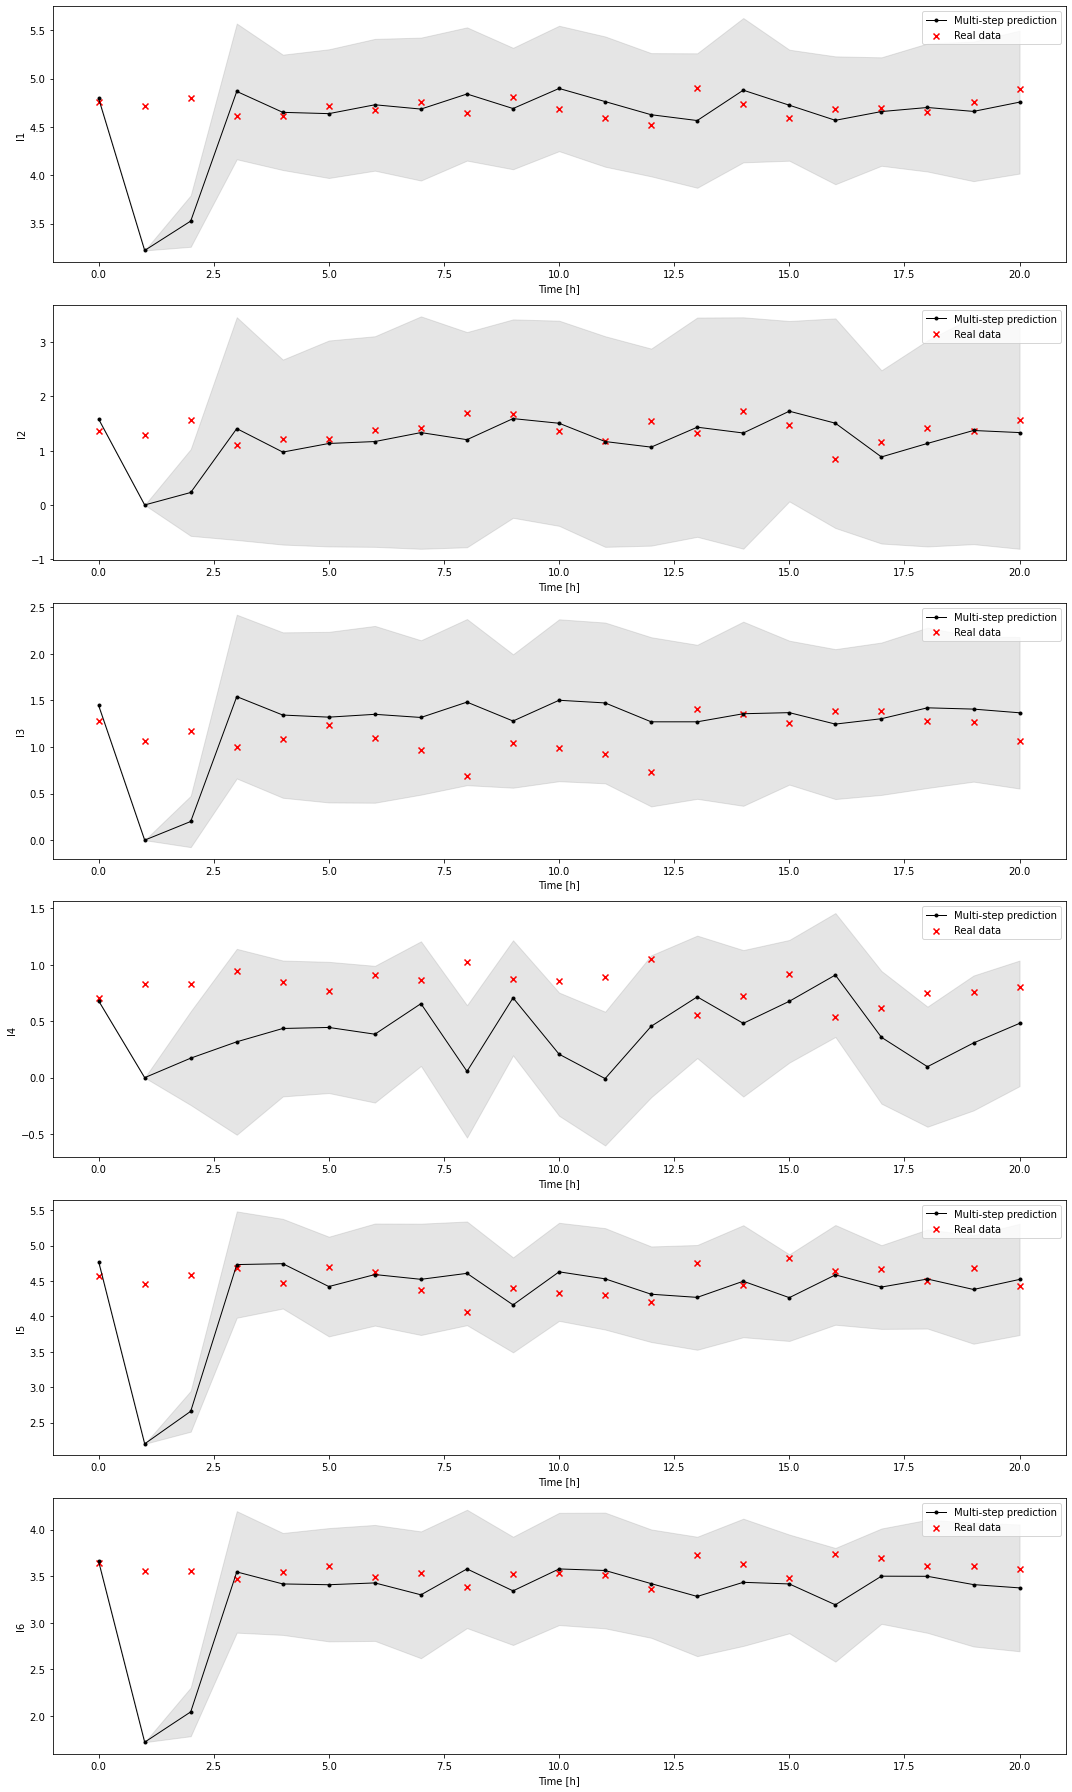

(<Figure size 1080x1800 with 6 Axes>, <Figure size 1080x1080 with 8 Axes>)

In [18]:
x_pred_var, u= mpc.solve_1(x0, u0=u0, sim_time=20*dt, x_sp=x_sp, debug=False)
mpc.plot_1(Y_test = Y_test, xnames=['I1', 'I2', 'I3', 'I4', 'I5', 'I6'],
         unames=['Load1', 'Load2', 'Load3', 'Gen2', 'W1', 'W2', 'S1', 'S2'])

# 2. ME

# GP

In [5]:
""" Time Sampling """
dt = 1


""" Options for hyper-parameter optimization """
solver_opts = {}
#solver_opts['ipopt.linear_solver'] = 'ma27' # Faster plugin solver than default
solver_opts['expand']= False                # Choise between SX or MX graph


print('*****************')
print('GP')
print('*****************')
gp = GP(X_train, Y_train, dt, mean_func='zero', optimizer_opts=solver_opts, gp_method='ME', 
        normalize=True, multistart=1)

print('*****************')
print('Hyper_parameters')
print('*****************')
gp.print_hyper_parameters()

print('*****************')
print('Validation')
print('*****************')
MSE, SMSE, MNLP = gp.validate(X_test, Y_test)
print('MSE:', MSE)
print('SMSE:', SMSE)
print('MNLP:', MNLP)

size = gp.get_size()
print('size:',size)

*****************
GP
*****************

________________________________________
# Optimizing hyperparameters (N=200)
----------------------------------------


C:\Users\MILE\Desktop\MPCGP Los.Alam - finished project\MPC_GP\optimize.py:467: OptimizeWarning: Unknown solver options: expand
  method='SLSQP', options=options, bounds=bounds, tol=1e-12)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1059.4526252249625
            Iterations: 69
            Function evaluations: 1742
            Gradient evaluations: 65
* State 0:  25.144657 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -555.4231777553157
            Iterations: 72
            Function evaluations: 1829
            Gradient evaluations: 71
* State 1:  21.881840 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -253.10893579094096
            Iterations: 289
            Function evaluations: 5378
            Gradient evaluations: 289
* State 2:  77.500795 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -305.53059145254736
            Iterations: 793
            Function evaluations: 14877
            Gradient evaluations: 793
* State 3:  172.468626 s
Optimization terminated successfully.    (E

# MPC

In [8]:
""" Limits in the MPC problem """
#ulb = [0.,    0.,  0.,   -150.]
#uub = [133., 116., 62.,   50.]
#xlb = [4,   0.5,   0.05,   0.1,     3.2]
#xub = [5.2,    2,     2,     1.7,     5.2]


ulb = [df['Load1'].min(), df['Load2'].min(), df['Load3'].min(), df['Gen2'].min()]
uub = [df['Load1'].max(), df['Load2'].max(), df['Load3'].max(), df['Gen2'].max()]
#xlb = [df['I1'].min(), df['I2'].min(), df['I3'].min(), df['I4'].min(), df['I5'].min(), df['I6'].min(), df['V4'].min()]
#xub = [df['I1'].max(), df['I2'].max(), df['I3'].max(), df['I4'].max(), df['I5'].max(), df['I6'].max(), df['V4'].max()]

xlb = [df['I1'].min(), df['I2'].min(), df['I3'].min(), df['I4'].min(), df['I5'].min(), df['I6'].min()]
xub = [df['I1'].max(), df['I2'].max(), df['I3'].max(), df['I4'].max(), df['I5'].max(), df['I6'].max()]



""" Initial state, input and set point  """
#x_sp = np.array([4.5, 1.2, 1, 1.2, 4.2])

x_sp = np.array([df['I1'].mean(), df['I2'].mean(), df['I3'].mean(), df['I4'].mean(), df['I5'].mean(), df['I6'].mean()])
x0 = x0
u0 = u0


""" Penalty matrices """
#Q = np.diag([10, 10])  
#R = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
#S = np.diag([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

""" Options to pass to the MPC solver """
solver_opts = {
            #'ipopt.linear_solver' : 'ma27',    # Plugin solver from HSL
            'ipopt.max_cpu_time' : 250,
            'expand' : True,
            'ipopt.expect_infeasible_problem' : 'yes'
}




""" Build MPC solver """
mpc = MPC(horizon=5*dt, Xd=X_d, gp=gp,
           gp_method='ME',
           ulb=ulb, uub=uub, xlb=xlb, xub=xub, Q=None, R=None, S=None,
           terminal_constraint=None, costFunc='quad', feedback=False,
           solver_opts=solver_opts, discrete_method='gp'
           )


________________________________________
# Time to build mpc solver: 62.161544 sec
# Number of variables: 236
# Number of equality constraints: 162
# Number of inequality constraints: 100
----------------------------------------



Solving MPC with 5 step horizon

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

* t=0.000000: Solve_Succeeded - 47.573863 sec
* t=1.000000: Solve_Succeeded - 2.470590 sec
* t=2.000000: Solve_Succeeded - 4.902202 sec
* t=3.000000: Solve_Succeeded - 5.681757 sec
* t=4.000000: Solve_Succeeded - 0.755569 sec
* t=5.000000: Solve_Succeeded - 0.701599 sec
* t=6.000000: Solve_Succeeded - 3.904773 sec
* t=7.000000: Solve_Succeeded - 4.343522 sec
* t=8.000000: Solve_Succeeded - 5.156057 sec
* t=9.000000: Solve_Succeeded - 4.641353 sec
* t=10.000000: Solve_Succeeded - 4.331529 sec
* t=11.000000: Solve_Succeeded - 1.075385 sec
* t=12.000000: Solve_Succeeded - 4.5

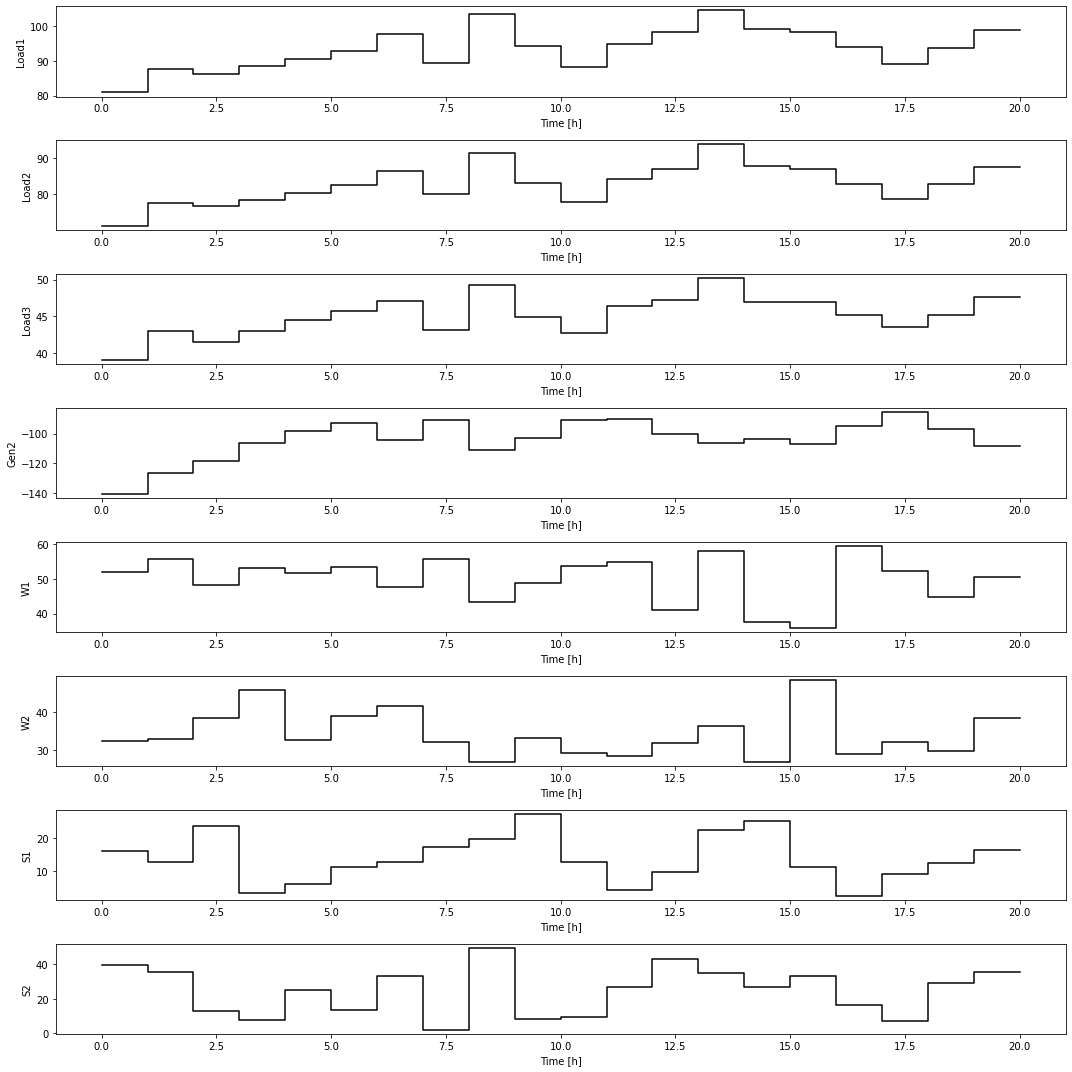

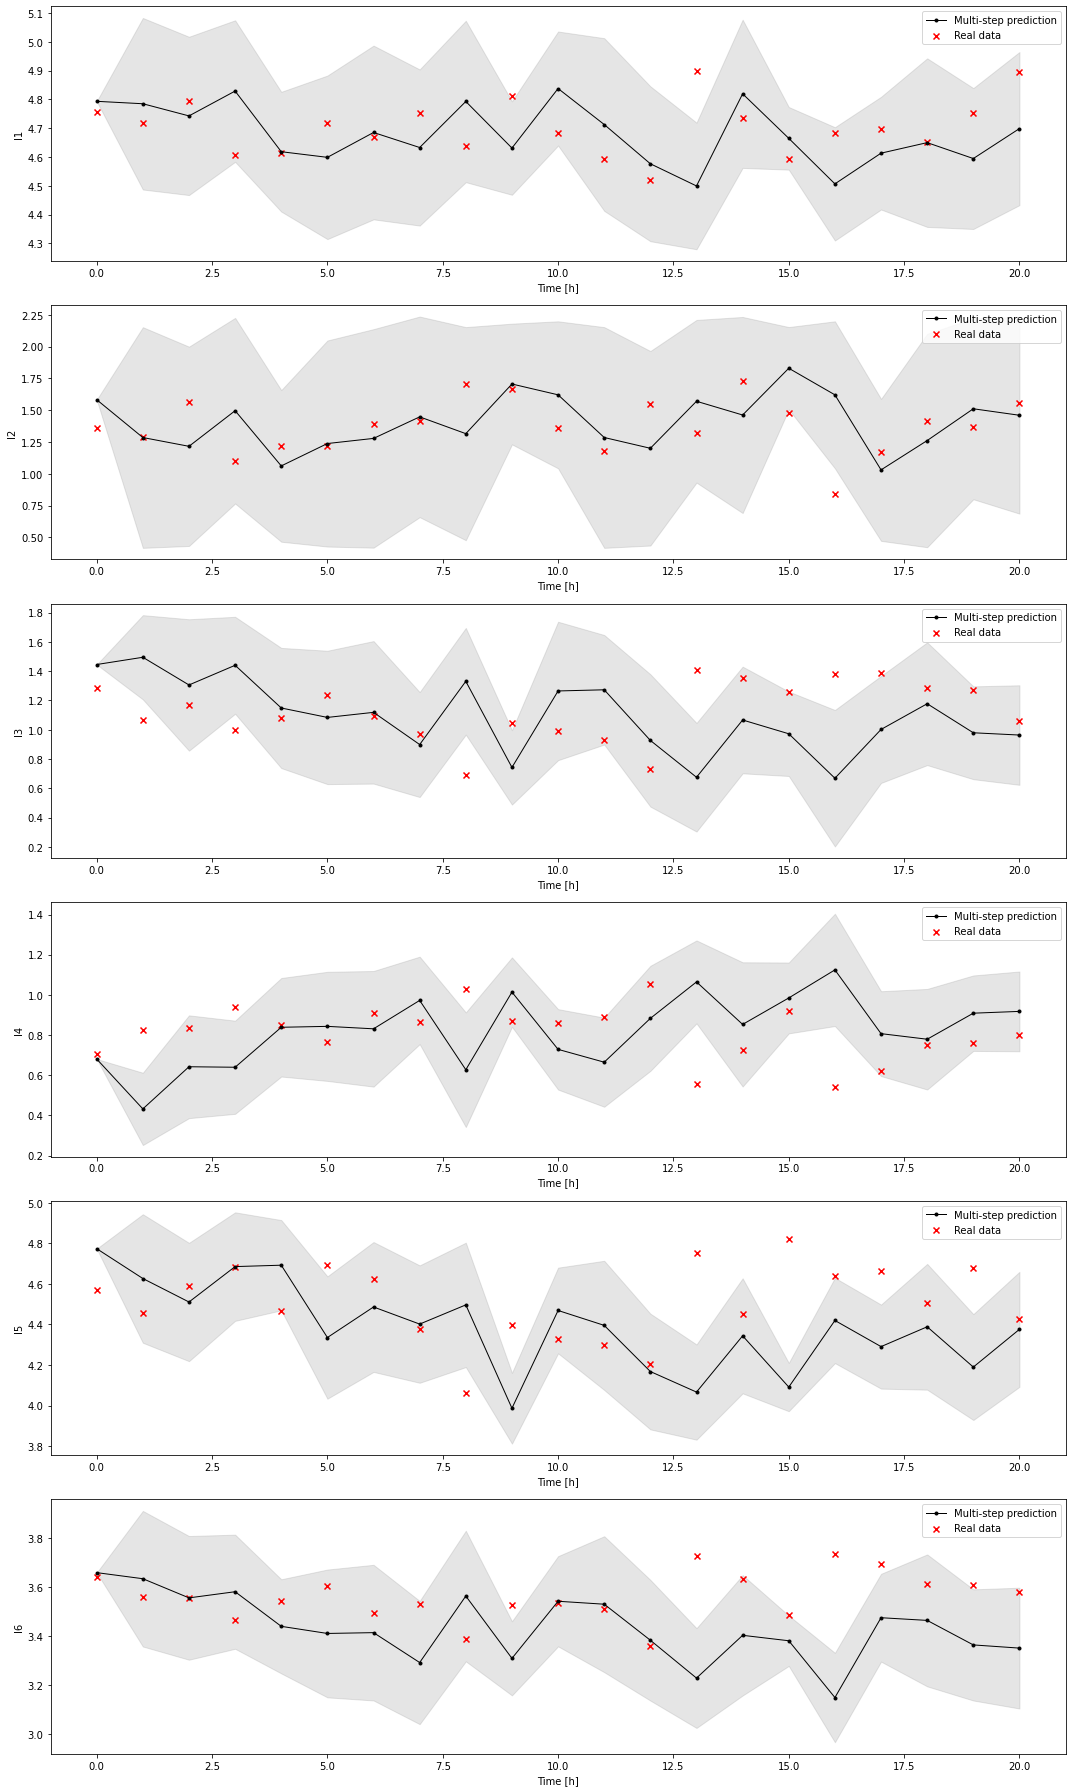

(<Figure size 1080x1800 with 6 Axes>, <Figure size 1080x1080 with 8 Axes>)

In [9]:
x_pred_var, u= mpc.solve_1(x0, u0=u0, sim_time=20*dt, x_sp=x_sp, debug=False)
mpc.plot_1(Y_test = Y_test, xnames=['I1', 'I2', 'I3', 'I4', 'I5', 'I6'],
         unames=['Load1', 'Load2', 'Load3', 'Gen2', 'W1', 'W2', 'S1', 'S2'])